<a href="https://colab.research.google.com/github/AhmedB479/Brain-Tumor-Detection/blob/main/Brain_Tumor_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

100%|██████████| 149M/149M [00:00<00:00, 226MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall

In [3]:
import pathlib
data_dir = '/root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Training'
print(len(list(data_dir)))

92


In [79]:
batch_size = 32
img_height = 236
img_width = 236
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset="training",
    seed=123,
    batch_size=batch_size
)

Found 5712 files belonging to 4 classes.
Using 4570 files for training.


In [80]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset="validation",
    seed=123,
    batch_size=batch_size
)

Found 5712 files belonging to 4 classes.
Using 1142 files for validation.


In [81]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    '/root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Testing',
)

Found 1311 files belonging to 4 classes.


In [82]:
test_labels = test_ds.class_names

In [83]:
class_names = train_ds.class_names
print(class_names)
num_classes = len(class_names)
print(num_classes)

['glioma', 'meningioma', 'notumor', 'pituitary']
4


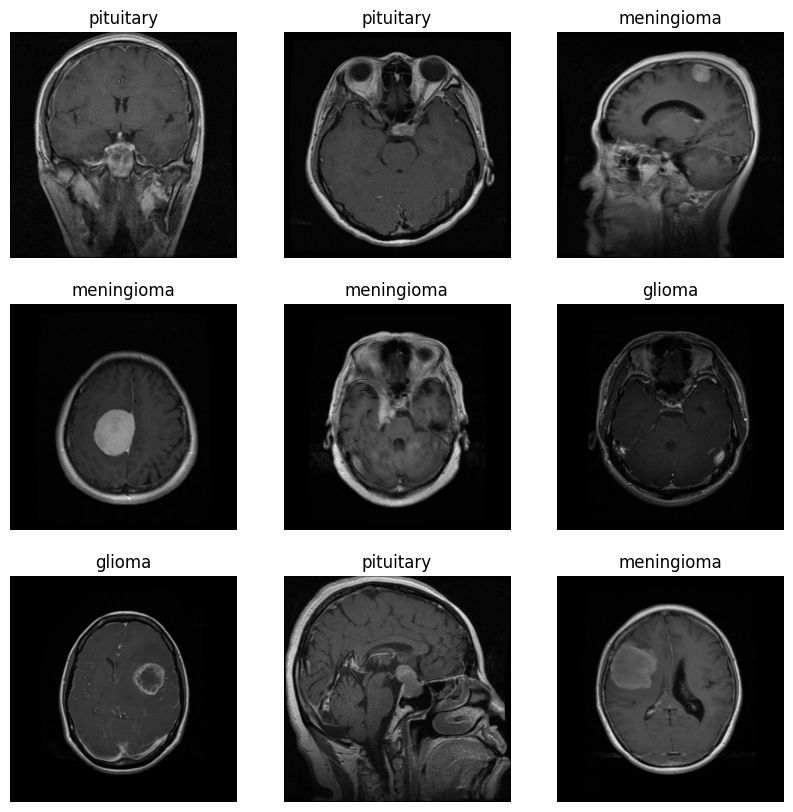

In [84]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [41]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


## Simple CNN

In [42]:
model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_35 (Conv2D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_36 (Conv2D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_37 (Conv2D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [12]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3
)

## Using Xception

In [47]:
img_shape=(256,256,3)
base_model = tf.keras.applications.Xception(include_top= False, weights= "imagenet",
                            input_shape= img_shape, pooling= 'max')

# for layer in base_model.layers:
#     layer.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dropout(rate= 0.3),
    Dense(128, activation= 'relu'),
    Dropout(rate= 0.25),
    Dense(num_classes,activation="softmax")
])

model.compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy',
                        Precision(),
                        Recall()])

model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 2048)                │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_12 (Flatten)                 │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,124,268 (80.58 MB)

 Trainable params: 21,069,740 (80.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [39]:
print(tf.config.list_physical_devices('TPU'))

[]


In [66]:
import tensorflow as tf

# Assuming train_ds and val_ds are properly formatted datasets
# Ensure you separate the features and labels in the dataset

def one_hot_encode(dataset, num_classes):
    return dataset.map(lambda x, y: (x, tf.one_hot(tf.cast(y, tf.int32), num_classes)))
# Example for 10 classes
num_classes = 4

# Apply one-hot encoding to the datasets
train_ds = one_hot_encode(train_ds, num_classes)
val_ds = one_hot_encode(val_ds, num_classes)

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3
)


Epoch 1/3
143/143 ━━━━━━━━━━━━━━━━━━━━ 91s 633ms/step - accuracy: 0.9780 - loss: 0.0717 - precision_10: 0.9821 - recall_10: 0.9763 - val_accuracy: 0.9623 - val_loss: 0.1013 - val_precision_10: 0.9631 - val_recall_10: 0.9597
Epoch 2/3
143/143 ━━━━━━━━━━━━━━━━━━━━ 130s 540ms/step - accuracy: 0.9888 - loss: 0.0343 - precision_10: 0.9911 - recall_10: 0.9883 - val_accuracy: 0.9466 - val_loss: 0.1677 - val_precision_10: 0.9473 - val_recall_10: 0.9440
Epoch 3/3
143/143 ━━━━━━━━━━━━━━━━━━━━ 80s 559ms/step - accuracy: 0.9918 - loss: 0.0297 - precision_10: 0.9926 - recall_10: 0.9910 - val_accuracy: 0.9746 - val_loss: 0.0971 - val_precision_10: 0.9746 - val_recall_10: 0.9729


## Output

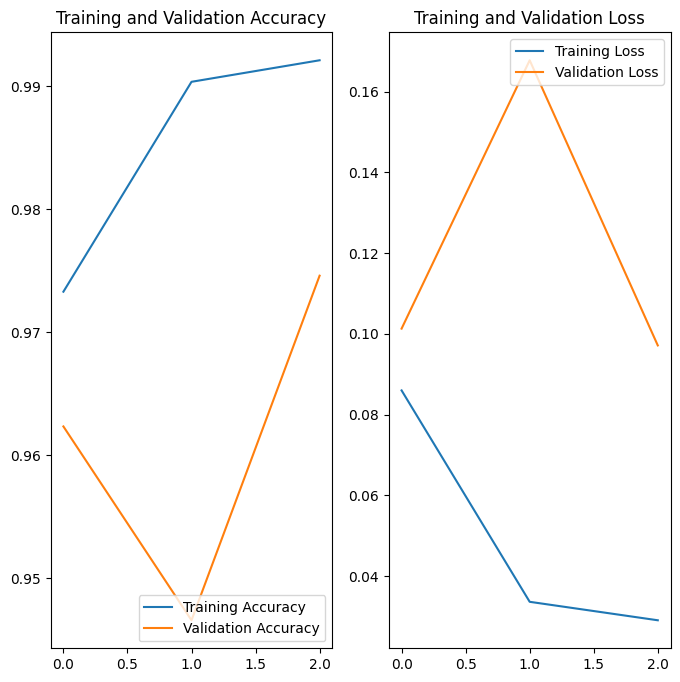

In [67]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(3)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [68]:
test_loss, test_acc = model.evaluate(test_ds)

ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(None,), output.shape=(None, 4)

In [71]:
test_loss, test_acc, test_precision, test_recall = model.evaluate(one_hot_encode(test_ds, num_classes))

41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 0.9717 - loss: 0.1221 - precision_10: 0.9717 - recall_10: 0.9701


In [72]:
model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 2048)                │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_12 (Flatten)                 │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 63,263,750 (241.33 MB)

 Trainable params: 21,069,740 (80.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

 Optimizer params: 42,139,482 (160.75 MB)

In [73]:
print('\nTest accuracy: {}'.format(test_acc))


Test accuracy: 0.9748283624649048


In [ ]:
model.save("/root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1")

In [77]:
from PIL import Image
import numpy as np
from skimage import transform

def load(filename):
    # Open the image and resize it
    np_image = np.array(Image.open(filename).resize((256, 256)))
    print(f"Initial image shape: {np_image.shape}")

    # Check if the image has 3 channels (RGB); if not, convert it
    if len(np_image.shape) == 2:  # Grayscale image
        np_image = np.stack((np_image,)*3, axis=-1)  # Convert grayscale to RGB

    print(f"Processed image shape (with channels): {np_image.shape}")

    # Normalize the image (values between 0 and 1)
    np_image = np_image.astype('float32') / 255.0

    # Add batch dimension (1, 256, 256, 3)
    np_image = np.expand_dims(np_image, axis=0)
    print(f"Image shape with batch dimension: {np_image.shape}")

    return np_image

image = load('Typical-MRI-scan-of-a-low-grade-glioma-histopathologically-defined-as-a-WHO-grade-II_Q320.jpg')

print(class_names)
tf.math.sigmoid(model.predict(image))

Initial image shape: (256, 256)
Processed image shape (with channels): (256, 256, 3)
Image shape with batch dimension: (1, 256, 256, 3)
['glioma', 'meningioma', 'notumor', 'pituitary']
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


<tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[0.55316085, 0.5423705 , 0.6040532 , 0.54841727]], dtype=float32)>